In [1]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.optimize import curve_fit
import pandas as pd
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/10.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/20.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_l

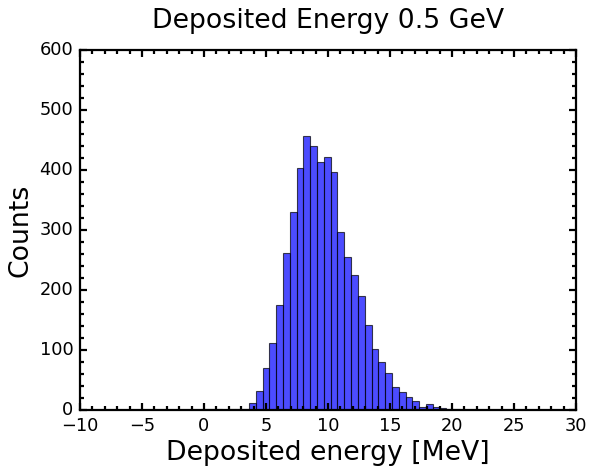

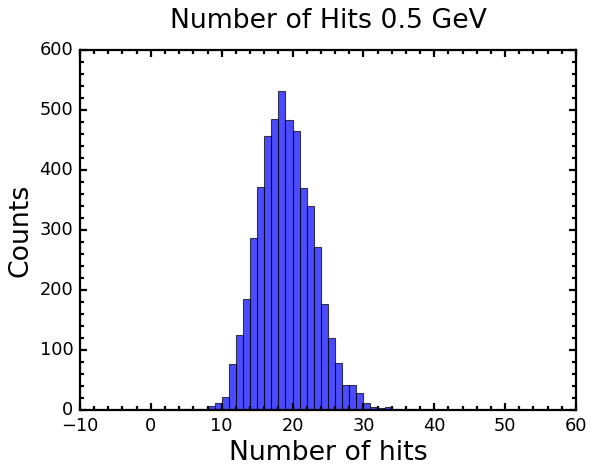

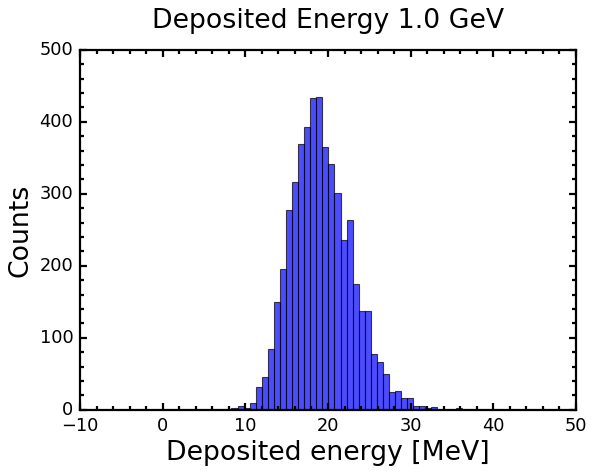

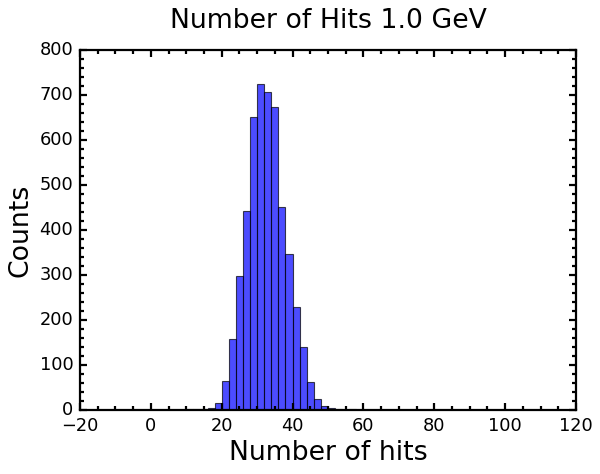

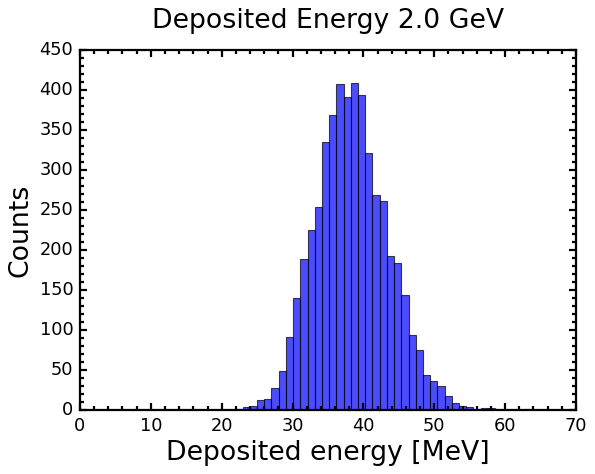

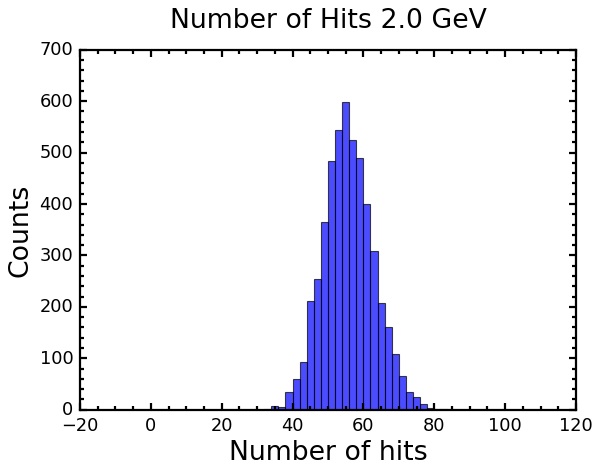

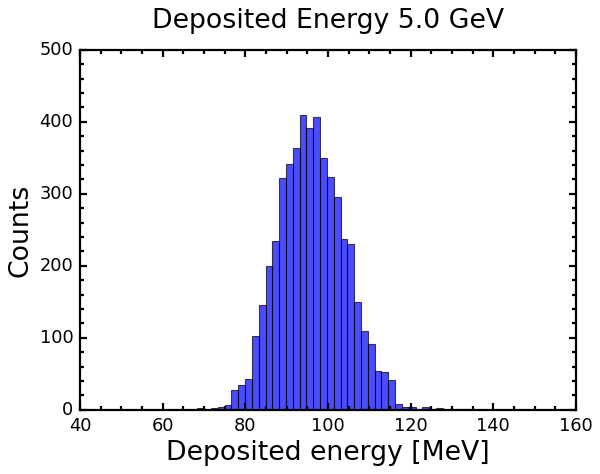

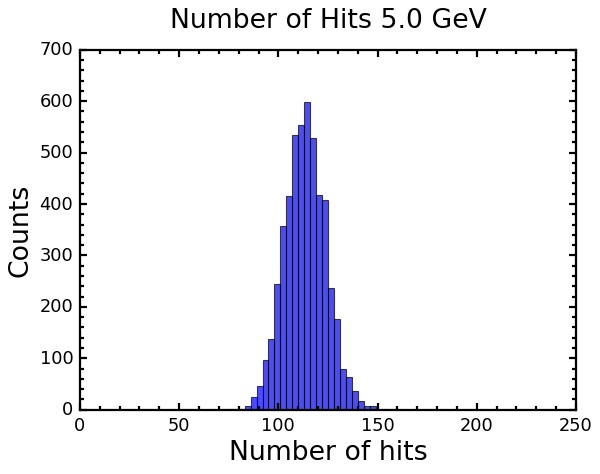

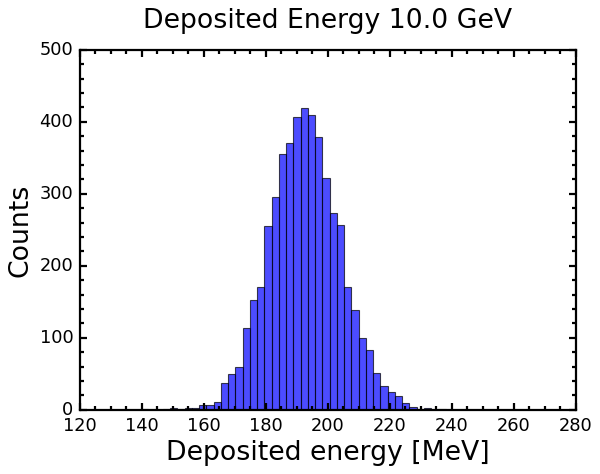

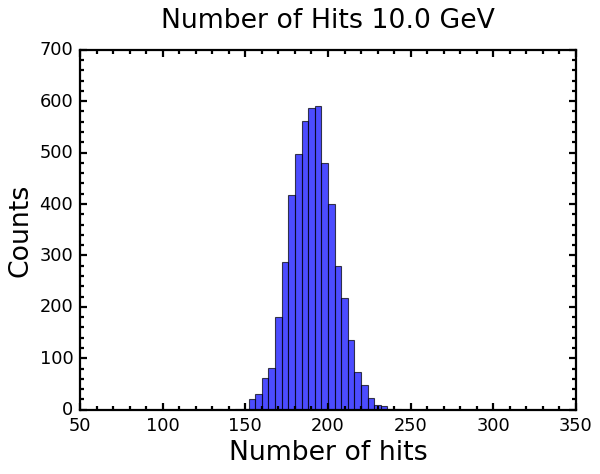

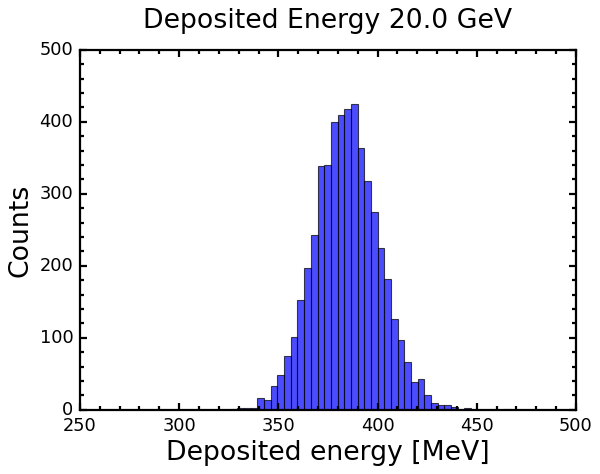

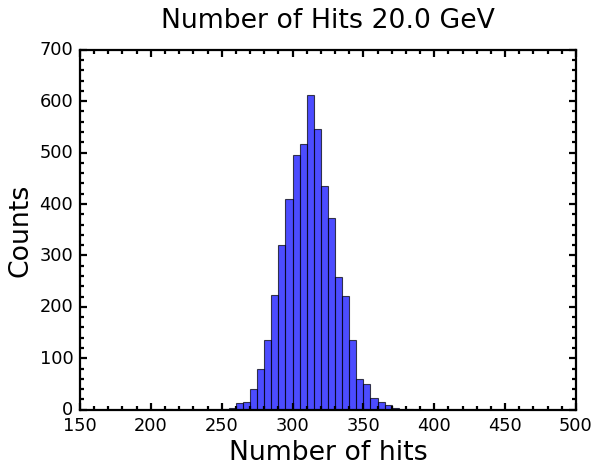

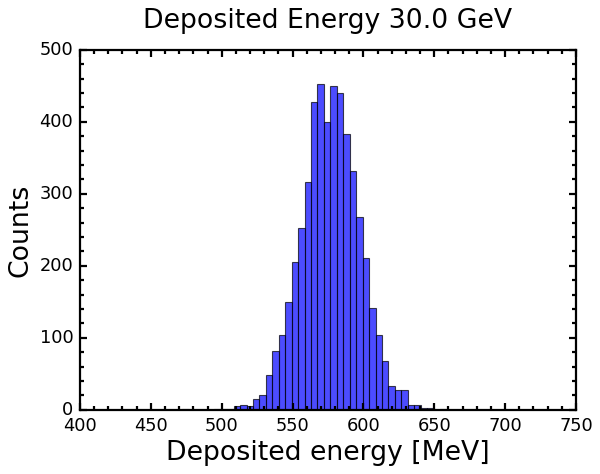

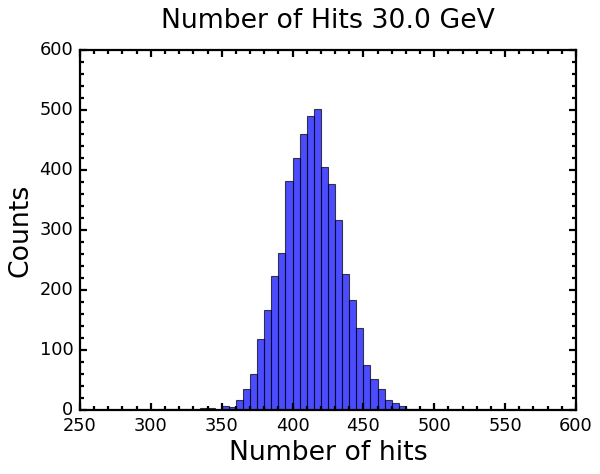

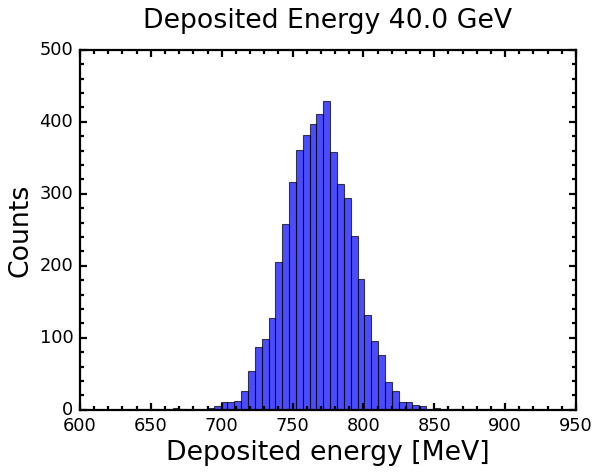

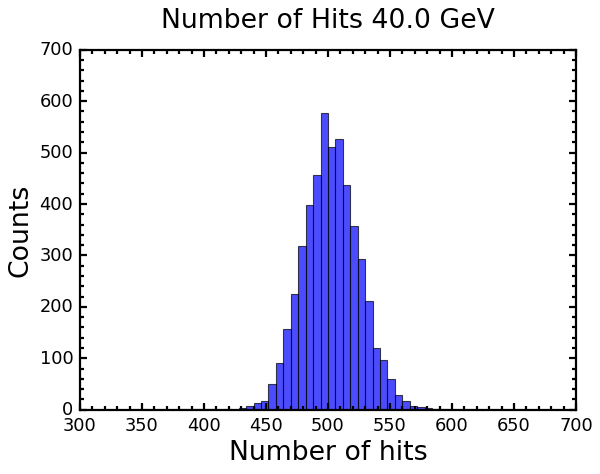

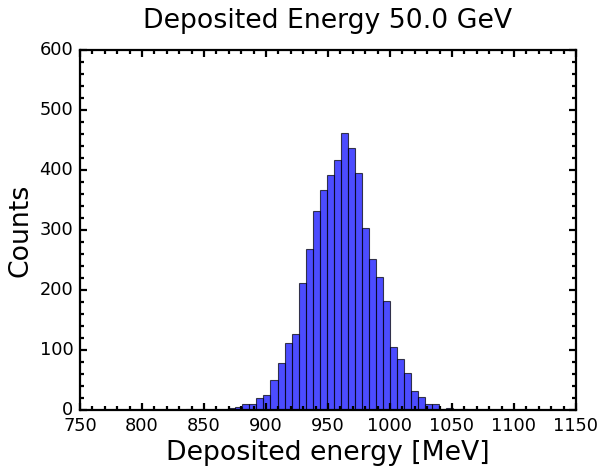

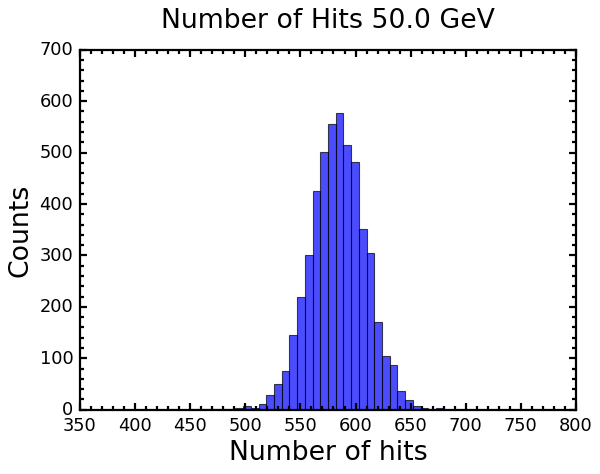

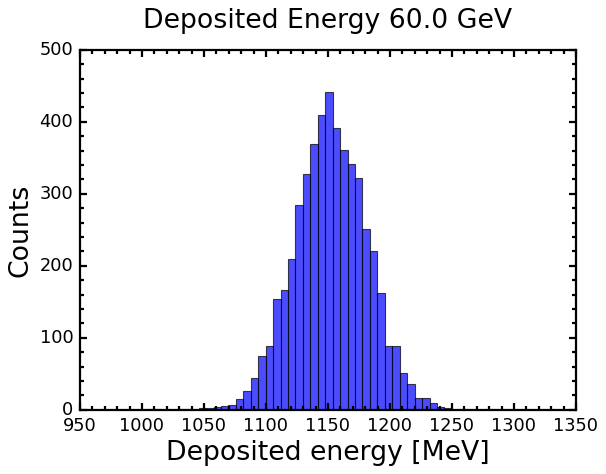

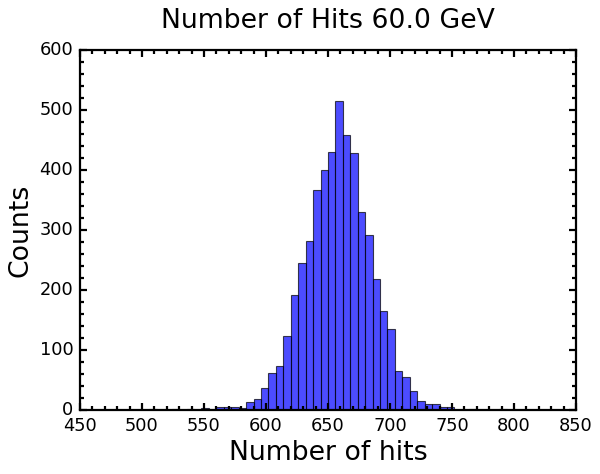

In [2]:
# 打开 ROOT 文件，载入 events tree
DataPath="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
ParticleEnergy=(0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
Fig_E = []
Fig_N = []
for i_E in range(len(ParticleEnergy)):
    input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    Event_energy = [np.sum(e) * 1000 for e in energy]
    Numer_hits = [len(e) for e in energy]

    #Sum of E
    Nbins=30
    counts, bin_edges = np.histogram(Event_energy, bins=Nbins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    peak_x = bin_centers[np.argmax(counts)]
    rms = np.sqrt(np.mean((Event_energy - peak_x)**2))
    fig,ax = plt.subplots(figsize=fig_size)
    ax.hist(Event_energy, bins=50, range=(peak_x - 5*rms, peak_x + 5*rms), color='blue', alpha=0.7)
    ax.set_xlabel("Deposited energy [MeV]")
    ax.set_ylabel("Counts")
    ax.set_title("Deposited Energy {:.1f} GeV".format(ParticleEnergy[i_E]))
    ax.grid(False)
    Fig_E.append(fig)
    #Number of hits
    counts, bin_edges = np.histogram(Numer_hits, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    peak_x = bin_centers[np.argmax(counts)]
    rms = np.sqrt(np.mean((Numer_hits - peak_x)**2))
    #Initialize range parameters
    fig,ax = plt.subplots(figsize=fig_size)
    ax.hist(Numer_hits, bins=50, range=( int((peak_x - 5*rms)/50)*50, int((peak_x + 5*rms)/50+1)*50 ), color='blue', alpha=0.7)
    ax.set_xlabel("Number of hits")
    ax.set_ylabel("Counts")
    ax.set_title("Number of Hits {:.1f} GeV".format(ParticleEnergy[i_E]))
    ax.grid(False)
    Fig_N.append(fig)


In [6]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(i_E, type):
    if type == "E":
        fig = Fig_E[i_E]
    elif type == "N":
        fig = Fig_N[i_E]
    else:
        raise ValueError("Type must be 'E' for energy or 'N' for number of hits.")
    ax = fig.axes[0] 
    patches = ax.patches
    counts = np.array([p.get_height() for p in patches])
    bin_edges = np.array([p.get_x() for p in patches] + [patches[-1].get_x() + patches[-1].get_width()])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mean = np.average(bin_centers, weights=counts)
    peak = bin_centers[np.argmax(counts)]
    rms = np.sqrt(np.mean((bin_centers - peak)**2))

    #Gamma Fit
    theta = abs(mean - peak)
    k = rms / np.sqrt(theta)
    mu = abs(mean - k*theta)
    params_gamma_initial = [sum(counts), k, mu, theta]
    lower_bounds = np.array(params_gamma_initial) * 0.5
    upper_bounds = np.array(params_gamma_initial) * 100
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / mean_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * mean_gamma - np.sqrt(k) * theta * (theta)) / (mean_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (mean_gamma**2)
    dr_dtheta = (np.sqrt(k) * mean_gamma - np.sqrt(k) * theta * (k - 1.0)) / (mean_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")

    #Gaussian Fit
    params_gauss_initial = np.array([max(counts), res_gamma, peak_gamma])
    lower_bounds = 0.5 * params_gauss_initial
    upper_bounds = 100 * params_gauss_initial
    print(f"Initial Gaussian Fit Parameters: {params_gauss_initial}")
    params_gauss, cov_gauss = curve_fit(fit_gaussian, bin_centers, counts, p0=params_gauss_initial, bounds=(lower_bounds, upper_bounds))
    peak_gauss = peak_gamma
    sigma_gauss = res_gamma * peak_gamma
    fit_mask = (bin_centers >= peak_gauss - 2 * sigma_gauss) & (bin_centers <= peak_gauss + 2 * sigma_gauss)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask]
    params_gauss, cov_gauss = curve_fit(fit_gaussian, x_fit, y_fit, p0=params_gauss_initial)
    x_fit_gauss = x_fit
    y_fit_gauss = fit_gaussian(x_fit, *params_gauss)
    peak_gauss = params_gauss[2]
    peak_gauss_error = np.sqrt(cov_gauss[2, 2])
    mean_gauss = peak_gauss
    mean_gauss_error = peak_gauss_error
    res_gauss = params_gauss[1]
    res_gauss_error = np.sqrt(cov_gauss[1, 1])
    print(f"Gaussian Fit Peak: {peak_gauss} ± {peak_gauss_error}, Resolution: {res_gauss} ± {res_gauss_error}")

    #Log Normal Fit
    var = rms**2
    sigma = np.sqrt(np.log(var/(mean**2)+1))
    scale = np.sqrt( var / ( np.exp(sigma**2) * (np.exp(sigma**2) - 1)) )
    loc = peak - scale*np.exp(-sigma**2)
    params_log_normal_initial = np.array([max(counts), sigma, loc, scale])
    lower_bounds = 0.001 * params_log_normal_initial
    upper_bounds = 1000 * params_log_normal_initial
    print(f"Initial Log Normal Fit Parameters: {params_log_normal_initial}")
    params_log_normal, cov_log_normal = curve_fit(fit_log_normal, bin_centers, counts, p0=params_log_normal_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Log Normal Fit Parameters: {params_log_normal}")
    x_fit_log_normal = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_log_normal = fit_log_normal(x_fit_log_normal, *params_log_normal)
    sigma, loc, scale = params_log_normal[1], params_log_normal[2], params_log_normal[3]
    peak_log_normal=loc + scale * np.exp(-sigma**2)
    mean_log_normal = loc + scale * np.exp(sigma**2 / 2)
    var = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2)
    res_log_normal = np.sqrt(var) / mean_log_normal    
    # ---- error propagation ----
    # partial derivatives for peak
    d_peak_d_sigma = -2 * sigma * scale * np.exp(-sigma**2)
    d_peak_d_loc = 1.0
    d_peak_d_scale = np.exp(-sigma**2)    
    # partial derivatives for variance
    d_var_d_sigma = (2*sigma*np.exp(sigma**2) * np.exp(2*np.log(scale) + sigma**2)
                     + (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * 2*sigma)
    d_var_d_scale = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * (2/scale)
    # derivatives for resolution
    d_res_d_sigma = (0.5 / np.sqrt(var) * d_var_d_sigma * peak - np.sqrt(var) * d_peak_d_sigma) / (peak**2)
    d_res_d_loc = -np.sqrt(var) * d_peak_d_loc / (peak**2)
    d_res_d_scale = (0.5 / np.sqrt(var) * d_var_d_scale * peak - np.sqrt(var) * d_peak_d_scale) / (peak**2)
    # errors
    peak_grad = np.array([0, d_peak_d_sigma, d_peak_d_loc, d_peak_d_scale])
    mean_grad = np.array([0, d_peak_d_sigma/2, d_peak_d_loc, d_peak_d_scale])  
    res_grad  = np.array([0, d_res_d_sigma, d_res_d_loc, d_res_d_scale])    
    peak_log_normal_error = np.sqrt(peak_grad @ cov_log_normal @ peak_grad)
    mean_log_normal_error = np.sqrt(mean_grad @ cov_log_normal @ mean_grad)
    res_log_normal_error  = np.sqrt(res_grad @ cov_log_normal @ res_grad)
    print(f"Log Normal Fit Peak: {peak_log_normal} ± {peak_log_normal_error}, Resolution: {res_log_normal} ± {res_log_normal_error}")

    plt.figure(figsize=fig_size)
    if type == "E":
        plt.title(f"Deposited Energy {ParticleEnergy[i_E]} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {ParticleEnergy[i_E]} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')
    plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")
    plt.plot(x_fit_gamma, y_fit_gamma, 'g-', label="Gamma Fit")
    plt.plot(x_fit_log_normal, y_fit_log_normal, 'm-', label="Log Normal Fit")
    plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
            mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
            mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error)



<>:132: SyntaxWarning: invalid escape sequence '\s'
<>:132: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3179591/3656913884.py:132: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")


Initial Gamma Fit Parameters: [np.float64(4997.0), np.float64(73.59433170531848), np.float64(1050.0790660750613), np.float64(1.3877590897800474)]
Gamma Fit Parameters: [2.99469431e+04 4.69722129e+02 5.25039535e+02 1.33687190e+00]
Gamma Fit Peak: 1152.997848090953 ± 0.5435821515995589, Resolution: 0.0251293819486606 ± 0.0003013238767509241
Initial Gaussian Fit Parameters: [4.41000000e+02 2.51293819e-02 1.15166098e+03]
Gaussian Fit Peak: 1152.3349892371216 ± 0.5794246412059387, Resolution: 0.025164510603150125 ± 0.0005503635600743335
Initial Log Normal Fit Parameters: [4.41000000e+02 7.51374426e-02 8.32848051e+00 1.14896238e+03]
Log Normal Fit Parameters: [2.99506298e+04 2.51288603e-02 8.32858729e-03 1.15250254e+03]
Log Normal Fit Peak: 1151.7833422234212 ± 0.5360991442364182, Resolution: 0.02513264626413371 ± 0.00029972911542468575


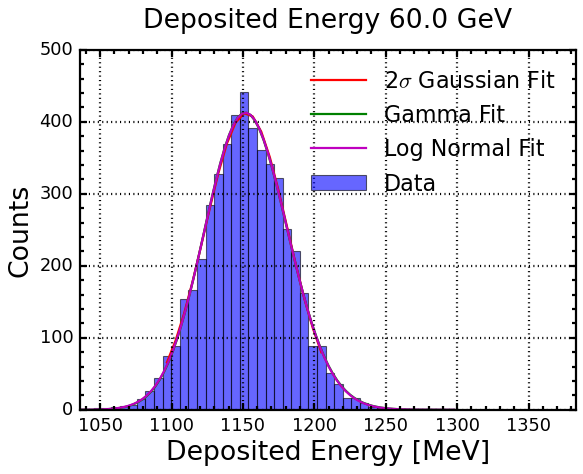

In [7]:
#This cell is left here for debug
(mean_gauss,mean_gauss_error,peak_gauss,peak_gauss_error,res_gauss,res_gauss_error,
 mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error,
 mean_log_normal,mean_log_normal_error,peak_log_normal,peak_log_normal_error,res_log_normal,res_log_normal_error) = fit_all(9,"E")




Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(6.883944755450116), np.float64(0.5039970258234128), np.float64(1.3246926949501034)]
Gamma Fit Parameters: [2.73657191e+03 1.13138189e+01 1.12562148e+00 7.53193538e-01]
Gamma Fit Peak: 9.647116771082178 ± 0.03968703089068194, Resolution: 0.26261145233549565 ± 0.0037181658045837354
Initial Gaussian Fit Parameters: [4.56000000e+02 2.62611452e-01 8.89392323e+00]
Gaussian Fit Peak: 9.212479651850945 ± 0.07747129274952541, Resolution: 0.257625197834389 ± 0.009365124045743217
Initial Log Normal Fit Parameters: [456.           0.71940043   3.8707971    7.42905631]
Log Normal Fit Parameters: [2.75218005e+03 2.67371309e-01 3.87079710e-03 9.43463988e+00]
Log Normal Fit Peak: 8.787595927091417 ± 0.042189155802593734, Resolution: 0.2721139440002763 ± 0.006877895926450773


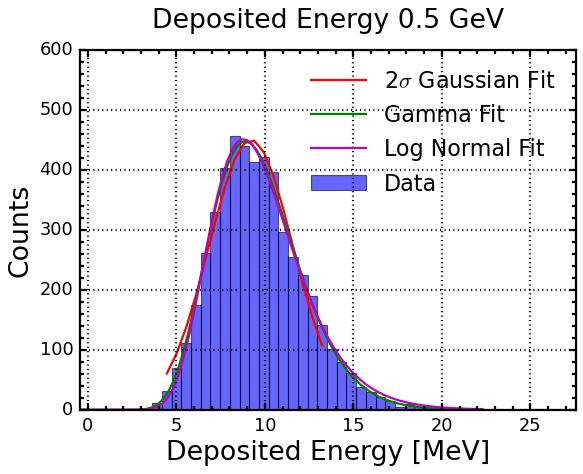

Initial Gamma Fit Parameters: [np.float64(4999.0), np.float64(20.668207358658993), np.float64(13.79755145317898), np.float64(0.26210142817824433)]
Gamma Fit Parameters: [3.66121785e+03 1.14851044e+01 6.89877573e+00 1.08081518e+00]
Gamma Fit Peak: 19.31205081708906 ± 0.07537493476730492, Resolution: 0.18966644820747103 ± 0.0033640909574674267
Initial Gaussian Fit Parameters: [4.34000000e+02 1.89666448e-01 1.82312356e+01]
Gaussian Fit Peak: 18.714511479800418 ± 0.1150176134730908, Resolution: 0.1855675199124692 ± 0.006728388359723368
Initial Log Normal Fit Parameters: [434.           0.51464983   6.03773993  16.83136872]
Log Normal Fit Parameters: [3.67088447e+03 1.89721946e-01 6.03774039e-03 1.89345143e+01]
Log Normal Fit Peak: 18.27113516379251 ± 0.07169125217345992, Resolution: 0.19138211229521201 ± 0.003811750030449739


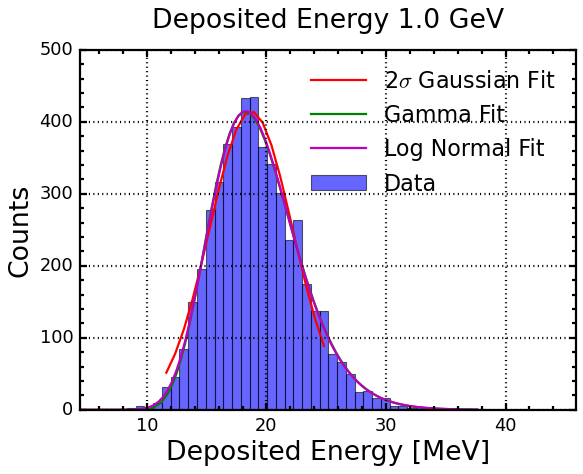

Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(25.75707672775353), np.float64(30.012930717180126), np.float64(0.32582539272308253)]
Gamma Fit Parameters: [5.08923730e+03 2.09958292e+01 1.50064654e+01 1.12479422e+00]
Gamma Fit Peak: 38.622452617739064 ± 0.10258497954013386, Resolution: 0.13344421206511914 ± 0.002038549842970613
Initial Gaussian Fit Parameters: [4.08000000e+02 1.33444212e-01 3.74976584e+01]
Gaussian Fit Peak: 38.01322060349646 ± 0.11135128616872406, Resolution: 0.13172307890359003 ± 0.0031733277142803836
Initial Log Normal Fit Parameters: [4.08000000e+02 3.69811778e-01 7.44875484e+00 3.58668526e+01]
Log Normal Fit Parameters: [5.09635539e+03 1.33338502e-01 7.44875484e-03 3.82212832e+01]
Log Normal Fit Peak: 37.55519503374105 ± 0.0960309836080407, Resolution: 0.1339074988501563 ± 0.0020546123766504087


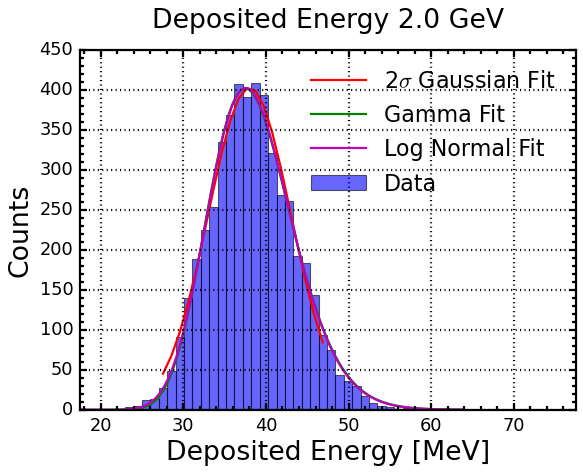

Initial Gamma Fit Parameters: [np.float64(4998.0), np.float64(15.996617647917601), np.float64(60.682153244627926), np.float64(2.2193490181411875)]
Gamma Fit Parameters: [8.30659717e+03 5.53294716e+01 3.48802550e+01 1.10967454e+00]
Gamma Fit Peak: 96.27796077444336 ± 0.14915641356459752, Resolution: 0.08573279825164422 ± 0.0010676422674428532
Initial Gaussian Fit Parameters: [4.10000000e+02 8.57327983e-02 9.51682862e+01]
Gaussian Fit Peak: 95.69361076394753 ± 0.17456999845251933, Resolution: 0.08545168270648654 ± 0.0019767433366401194
Initial Log Normal Fit Parameters: [4.10000000e+02 2.44082458e-01 6.00322041e+00 9.33613363e+01]
Log Normal Fit Parameters: [8.31050568e+03 8.65144885e-02 8.71746757e-01 9.50294719e+01]
Log Normal Fit Peak: 95.19260139397045 ± 0.1487331465116795, Resolution: 0.08589164784683596 ± 0.0011394315797835695


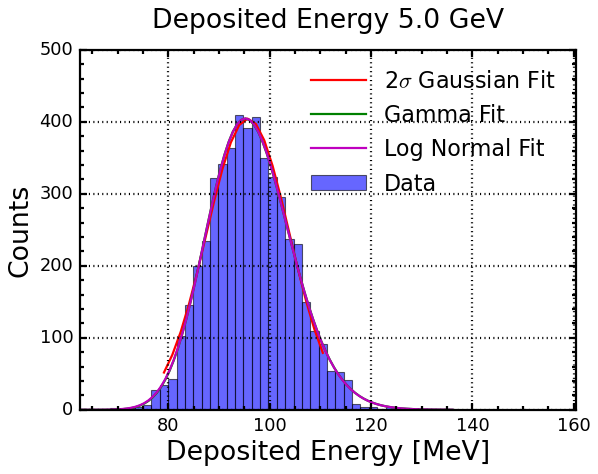

Initial Gamma Fit Parameters: [np.float64(4998.0), np.float64(148.82340590592528), np.float64(184.74217562644853), np.float64(0.05144615982379719)]
Gamma Fit Parameters: [1.16265132e+04 7.90867261e+01 9.23710878e+01 1.27009161e+00]
Gamma Fit Peak: 192.81847537567108 ± 0.17639182079139645, Resolution: 0.058578494084399045 ± 0.0006123284815269543
Initial Gaussian Fit Parameters: [4.19000000e+02 5.85784941e-02 1.91548384e+02]
Gaussian Fit Peak: 192.15116667696967 ± 0.16920216101595956, Resolution: 0.05816062486393025 ± 0.0009606106812500647
Initial Log Normal Fit Parameters: [4.19000000e+02 1.74118894e-01 8.50212181e+00 1.89504051e+02]
Log Normal Fit Parameters: [1.16310369e+04 5.85266281e-02 8.50212239e-03 1.92337155e+02]
Log Normal Fit Peak: 191.687959419132 ± 0.16521084212458384, Resolution: 0.05857419790199804 ± 0.0005782273355281514


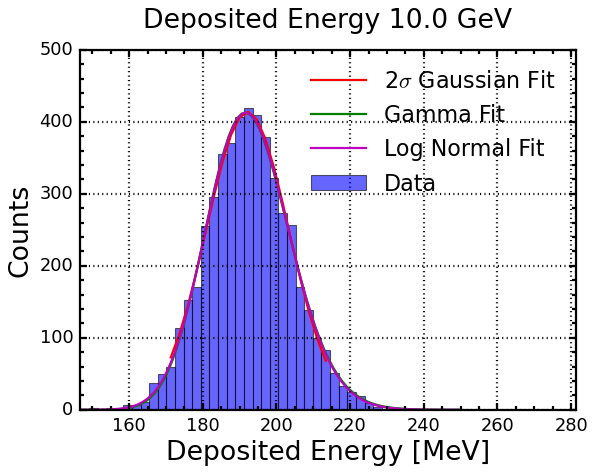

Initial Gamma Fit Parameters: [np.float64(4996.0), np.float64(24.96296743536418), np.float64(288.9924813390128), np.float64(3.8223721494285314)]
Gamma Fit Parameters: [1.67433471e+04 7.04253881e+01 2.50356151e+02 1.91118607e+00]
Gamma Fit Peak: 384.95217240045565 ± 0.23988507431063605, Resolution: 0.04166398653429692 ± 0.00041661284523022827
Initial Gaussian Fit Parameters: [4.24000000e+02 4.16639865e-02 3.83040986e+02]
Gaussian Fit Peak: 383.93129562712676 ± 0.22195704386944262, Resolution: 0.04114437830588577 ± 0.0006258704325042857
Initial Log Normal Fit Parameters: [4.24000000e+02 1.26453050e-01 1.29329690e+01 3.81349055e+02]
Log Normal Fit Parameters: [1.67254908e+04 4.14420414e-02 1.29329690e-02 3.84140431e+02]
Log Normal Fit Peak: 383.49419096980535 ± 0.2141859326874267, Resolution: 0.04145844679645047 ± 0.00036012045828597196


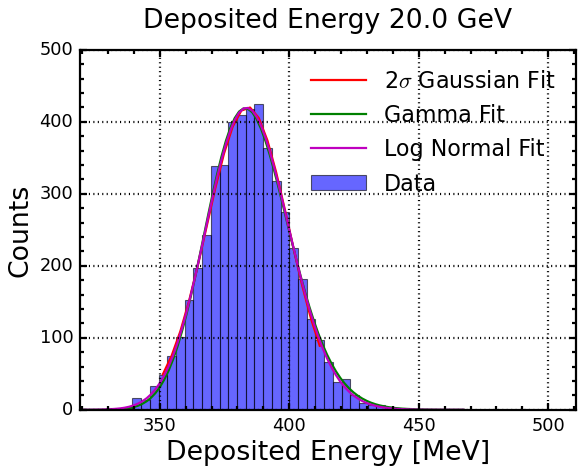

Initial Gamma Fit Parameters: [np.float64(4995.0), np.float64(25.661506129432706), np.float64(403.6240765197443), np.float64(6.741648010925928)]
Gamma Fit Parameters: [2.27139379e+04 3.62347066e+01 4.56192075e+02 3.37082401e+00]
Gamma Fit Peak: 578.3328934155757 ± 0.5241456333011342, Resolution: 0.03508492548157188 ± 0.000628456494463928
Initial Gaussian Fit Parameters: [4.52000000e+02 3.50849255e-02 5.74962069e+02]
Gaussian Fit Peak: 576.6477513378907 ± 0.4652705511767972, Resolution: 0.0345825307908588 ± 0.00088978981917181
Initial Log Normal Fit Parameters: [4.52000000e+02 1.15167545e-01 4.61713558e+00 5.72813520e+02]
Log Normal Fit Parameters: [2.26519754e+04 3.45589416e-02 4.61713575e-03 5.76801919e+02]
Log Normal Fit Peak: 576.1180606239757 ± 0.4164081240012474, Resolution: 0.03456898622760476 ± 0.00047336876980443775


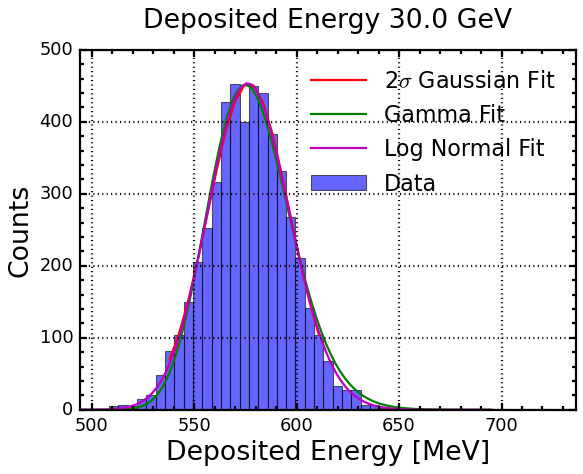

Initial Gamma Fit Parameters: [np.float64(4994.0), np.float64(29.322579222068274), np.float64(602.3333589023171), np.float64(5.6664133129188485)]
Gamma Fit Parameters: [2.41519491e+04 6.77804839e+01 5.77770911e+02 2.83320666e+00]
Gamma Fit Peak: 769.8070292732197 ± 0.40937137857406025, Resolution: 0.030300424542954837 ± 0.0003547343440402883
Initial Gaussian Fit Parameters: [4.29000000e+02 3.03004245e-02 7.66973823e+02]
Gaussian Fit Peak: 768.3951035725538 ± 0.36860974979957195, Resolution: 0.030241073737413332 ± 0.0005123387706897813
Initial Log Normal Fit Parameters: [4.29000000e+02 9.06414844e-02 1.50789913e+01 7.65336789e+02]
Log Normal Fit Parameters: [2.41275335e+04 3.01069513e-02 1.50790166e-02 7.68553199e+02]
Log Normal Fit Peak: 767.8719548479645 ± 0.35504588552007654, Resolution: 0.03011318449602251 ± 0.000294643155979617


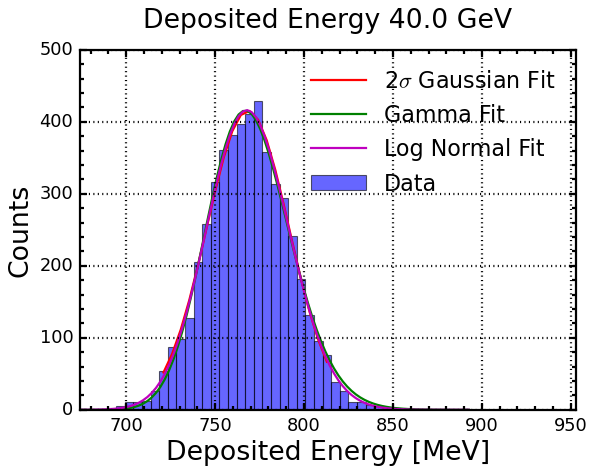

Initial Gamma Fit Parameters: [np.float64(4999.0), np.float64(55.408640374613725), np.float64(840.0995633388216), np.float64(2.1812059921750233)]
Gamma Fit Parameters: [2.82025846e+04 4.43142344e+02 4.20049782e+02 1.22197460e+00]
Gamma Fit Peak: 961.5584692308371 ± 0.48648161357478303, Resolution: 0.026752113930421376 ± 0.0003234825782758261
Initial Gaussian Fit Parameters: [4.61000000e+02 2.67521139e-02 9.60336495e+02]
Gaussian Fit Peak: 960.9057674383506 ± 0.5269730777074593, Resolution: 0.02662076026428227 ± 0.0005963200309937254
Initial Log Normal Fit Parameters: [4.61000000e+02 8.50034981e-02 1.25401983e+01 9.57491742e+02]
Log Normal Fit Parameters: [2.82047560e+04 2.67497435e-02 1.25402007e-02 9.61105514e+02]
Log Normal Fit Peak: 960.4305820889043 ± 0.48359529990427935, Resolution: 0.02675418048987287 ± 0.00032100675263209704


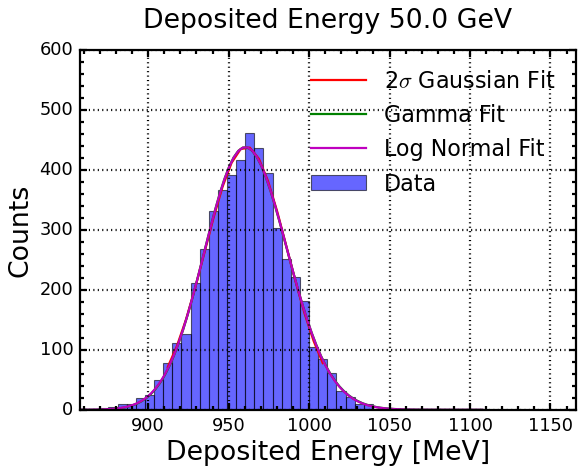

Initial Gamma Fit Parameters: [np.float64(4997.0), np.float64(73.59433170531848), np.float64(1050.0790660750613), np.float64(1.3877590897800474)]
Gamma Fit Parameters: [2.99469431e+04 4.69722129e+02 5.25039535e+02 1.33687190e+00]
Gamma Fit Peak: 1152.997848090953 ± 0.5435821515995589, Resolution: 0.0251293819486606 ± 0.0003013238767509241
Initial Gaussian Fit Parameters: [4.41000000e+02 2.51293819e-02 1.15166098e+03]
Gaussian Fit Peak: 1152.3349892371216 ± 0.5794246412059387, Resolution: 0.025164510603150125 ± 0.0005503635600743335
Initial Log Normal Fit Parameters: [4.41000000e+02 7.51374426e-02 8.32848051e+00 1.14896238e+03]
Log Normal Fit Parameters: [2.99506298e+04 2.51288603e-02 8.32858729e-03 1.15250254e+03]
Log Normal Fit Peak: 1151.7833422234212 ± 0.5360991442364182, Resolution: 0.02513264626413371 ± 0.00029972911542468575


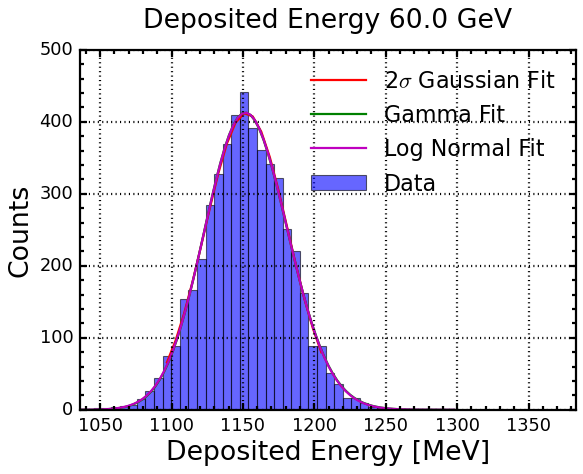

In [9]:
#Fit Sum of E and Save as CSV
results = []
for i_E in range(len(ParticleEnergy)):
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(i_E, "E")    
    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, "SumE_Fit.csv")
df.to_csv(outputfile_name, index=False)



Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(20.850536689733268), np.float64(7.06212075937569), np.float64(0.5762)]
Gamma Fit Parameters: [5.00606667e+03 1.58178573e+01 3.53106038e+00 9.97549123e-01]
Gamma Fit Peak: 19.310150005911236 ± 0.06995763501020127, Resolution: 0.20545772242900134 ± 0.0030092555773903852
Initial Gaussian Fit Parameters: [5.32000000e+02 2.05457722e-01 1.83126009e+01]
Gaussian Fit Peak: 18.784969306250556 ± 0.07967826804404562, Resolution: 0.20655151269709823 ± 0.004740426774546184
Initial Log Normal Fit Parameters: [532.           0.72371645   9.80460798  14.68106743]
Log Normal Fit Parameters: [5.01993656e+03 2.07373572e-01 9.80460798e-03 1.90047039e+01]
Log Normal Fit Peak: 18.214557811349366 ± 0.08095842321454398, Resolution: 0.2095173469164617 ± 0.0047105595697972975


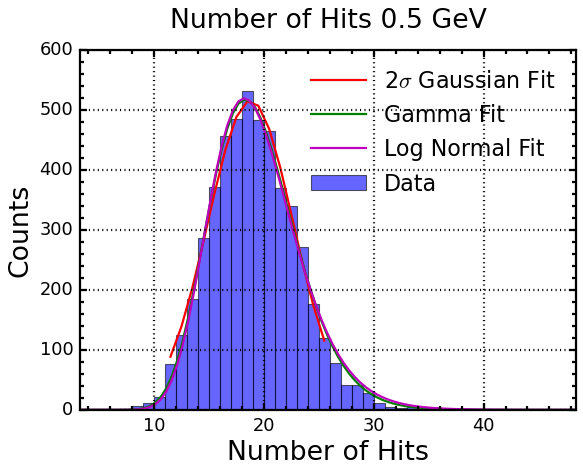

Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(27.192102774645985), np.float64(11.295007560498398), np.float64(1.6148000000000025)]
Gamma Fit Parameters: [1.00136986e+04 2.43076732e+01 5.64750378e+00 1.11959586e+00]
Gamma Fit Peak: 32.862274055165265 ± 0.09176703499730865, Resolution: 0.16797140887080264 ± 0.002151668276630264
Initial Gaussian Fit Parameters: [7.24000000e+02 1.67971409e-01 3.17426782e+01]
Gaussian Fit Peak: 32.22910147789358 ± 0.15104552936093618, Resolution: 0.1673620853142554 ± 0.0053306671467783255
Initial Log Normal Fit Parameters: [724.           0.86751408  20.4524337   22.386897  ]
Log Normal Fit Parameters: [1.00307514e+04 1.69037547e-01 2.04524337e-02 3.25148342e+01]
Log Normal Fit Peak: 31.619365720812027 ± 0.10255553684644371, Resolution: 0.17014676523284228 ± 0.0031158426158253826


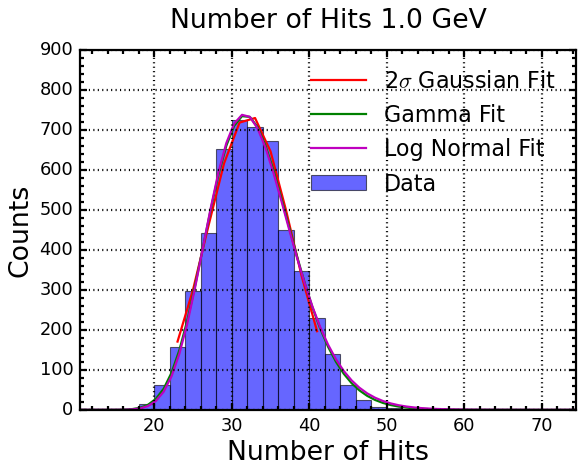

Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(33.45049831087261), np.float64(30.116957895222768), np.float64(0.7668000000000035)]
Gamma Fit Parameters: [9.94468395e+03 3.35612793e+01 1.50584789e+01 1.22021831e+00]
Gamma Fit Peak: 56.01056635678626 ± 0.11291494288344595, Resolution: 0.12620798292959604 ± 0.0014697756636434867
Initial Gaussian Fit Parameters: [5.98000000e+02 1.26207983e-01 5.47903480e+01]
Gaussian Fit Peak: 55.31853746169833 ± 0.13950028257237218, Resolution: 0.12412690652049957 ± 0.0027277954302818903
Initial Log Normal Fit Parameters: [5.98000000e+02 4.93602993e-01 1.63049053e+01 4.93706814e+01]
Log Normal Fit Parameters: [9.95648939e+03 1.26516186e-01 1.63049053e-02 5.56074576e+01]
Log Normal Fit Peak: 54.740775909576804 ± 0.11424257606684667, Resolution: 0.1269872057370011 ± 0.001686380550129246


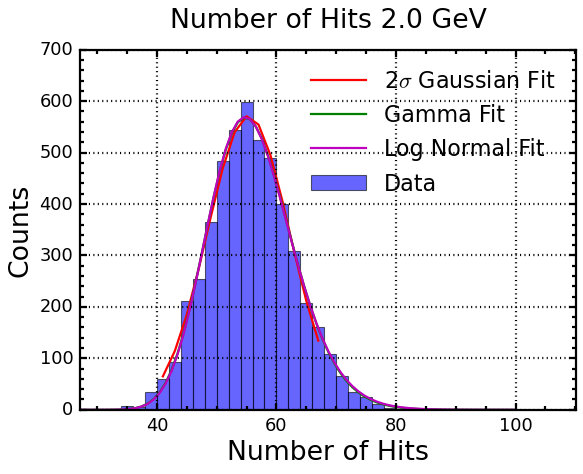

Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(43.338138029182225), np.float64(67.65232335836592), np.float64(1.056600000000003)]
Gamma Fit Parameters: [1.49979321e+04 5.95676520e+01 3.38261617e+01 1.34507950e+00]
Gamma Fit Peak: 113.9493895126077 ± 0.23637845724850245, Resolution: 0.09110478617192931 ± 0.0014270807312691948
Initial Gaussian Fit Parameters: [5.98000000e+02 9.11047862e-02 1.12604310e+02]
Gaussian Fit Peak: 113.25658540000207 ± 0.2660383090956847, Resolution: 0.09089672180993119 ± 0.0025342237223308123
Initial Log Normal Fit Parameters: [5.98000000e+02 3.78695134e-01 2.30137189e+01 1.05593734e+02]
Log Normal Fit Parameters: [1.50068621e+04 9.12063128e-02 2.30137189e-02 1.13489576e+02]
Log Normal Fit Peak: 112.57243218265192 ± 0.23773932474843484, Resolution: 0.0913778659883122 ± 0.0015125199606476367


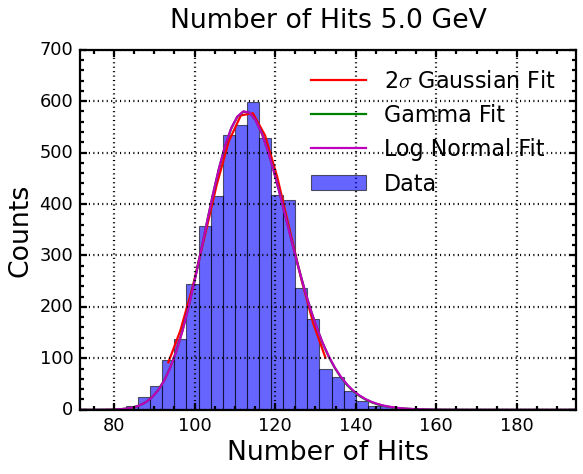

Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(31.675487541043847), np.float64(84.31492342222425), np.float64(3.3567999999999927)]
Gamma Fit Parameters: [1.99662425e+04 6.44985053e+01 8.27867434e+01 1.67840000e+00]
Gamma Fit Peak: 191.04103471803205 ± 0.16494760108345413, Resolution: 0.07055757309268065 ± 0.000586177174194259
Initial Gaussian Fit Parameters: [5.90000000e+02 7.05575731e-02 1.89362635e+02]
Gaussian Fit Peak: 190.16347579686632 ± 0.2522694740764469, Resolution: 0.07001889420278246 ± 0.0014586838331507458
Initial Log Normal Fit Parameters: [5.90000000e+02 2.97695053e-01 2.70874368e+01 1.82380004e+02]
Log Normal Fit Parameters: [1.99599994e+04 7.04158783e-02 2.70874385e-02 1.90409445e+02]
Log Normal Fit Peak: 189.49474344626475 ± 0.15821387823947758, Resolution: 0.07049325257248637 ± 0.0005631414019585532


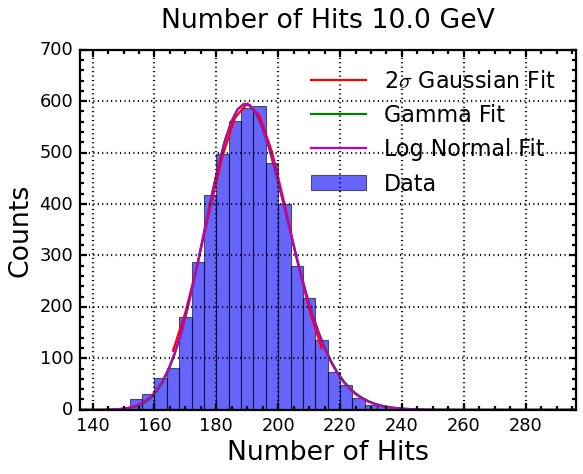

Initial Gamma Fit Parameters: [np.float64(5000.0), np.float64(122.56022357747302), np.float64(268.3890001828387), np.float64(0.35700000000002774)]
Gamma Fit Parameters: [2.49359782e+04 1.02145260e+02 1.34194500e+02 1.74596055e+00]
Gamma Fit Peak: 312.5360941677383 ± 0.33795900287920033, Resolution: 0.05646032257836129 ± 0.000716259100233958
Initial Gaussian Fit Parameters: [6.13000000e+02 5.64603226e-02 3.10790134e+02]
Gaussian Fit Peak: 311.63606840838355 ± 0.42748017228065305, Resolution: 0.05648217654224769 ± 0.0014940687812533627
Initial Log Normal Fit Parameters: [6.13000000e+02 2.31465938e-01 2.44607672e+01 3.03892243e+02]
Log Normal Fit Parameters: [2.49422966e+04 5.64367379e-02 2.44607672e-02 3.11885576e+02]
Log Normal Fit Peak: 310.9182283438758 ± 0.33053598221679115, Resolution: 0.05647728459305012 ± 0.0007091173227769047


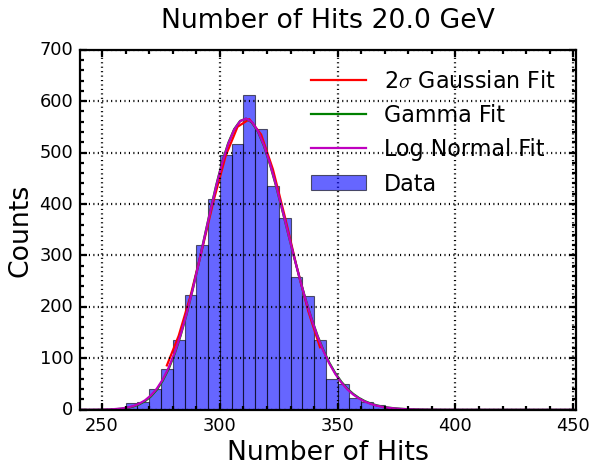

Initial Gamma Fit Parameters: [np.float64(4999.0), np.float64(36.54766455899649), np.float64(269.5701633347792), np.float64(3.939787957591534)]
Gamma Fit Parameters: [2.49525673e+04 1.10395011e+02 1.96756448e+02 1.96989398e+00]
Gamma Fit Peak: 414.22291562647274 ± 0.3532849160940709, Resolution: 0.04996702074029996 ± 0.0005622617789968521
Initial Gaussian Fit Parameters: [5.01000000e+02 4.99670207e-02 4.12253022e+02]
Gaussian Fit Peak: 413.170904204349 ± 0.384234049443396, Resolution: 0.04980424295218054 ± 0.000996195083420642
Initial Log Normal Fit Parameters: [5.01000000e+02 1.74083917e-01 2.23184402e+01 4.07340936e+02]
Log Normal Fit Parameters: [2.49339308e+04 4.98354474e-02 2.23184402e-02 4.13469567e+02]
Log Normal Fit Peak: 412.4662780057062 ± 0.3396167619206588, Resolution: 0.049863717683135605 ± 0.0005385825846646223


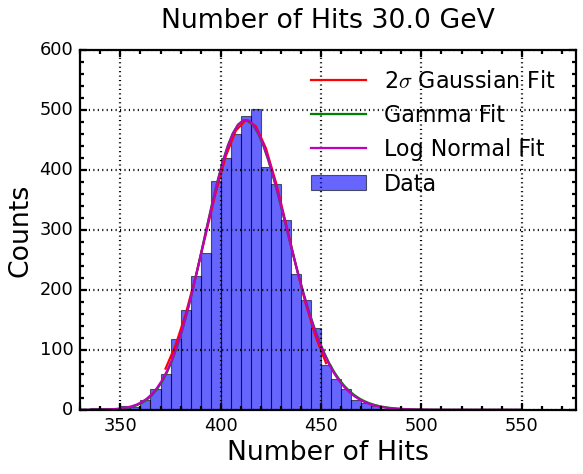

Initial Gamma Fit Parameters: [np.float64(4999.0), np.float64(36.81955165871227), np.float64(298.6776253631052), np.float64(5.536707341468286)]
Gamma Fit Parameters: [2.99189995e+04 6.49712105e+01 3.23527546e+02 2.76835367e+00]
Gamma Fit Peak: 503.39083500789593 ± 0.40985897556729467, Resolution: 0.04432785814615973 ± 0.0005468953834233788
Initial Gaussian Fit Parameters: [5.77000000e+02 4.43278581e-02 5.00622481e+02]
Gaussian Fit Peak: 501.90262334551096 ± 0.4794546127666164, Resolution: 0.044011556941930596 ± 0.0010300871442783268
Initial Log Normal Fit Parameters: [5.77000000e+02 1.71138912e-01 1.60631869e+01 4.95231051e+02]
Log Normal Fit Parameters: [2.98809187e+04 4.40650037e-02 1.60631869e-02 5.02225504e+02]
Log Normal Fit Peak: 501.2673296516982 ± 0.37952338518961376, Resolution: 0.0440849941994249 ± 0.0005008549099479983


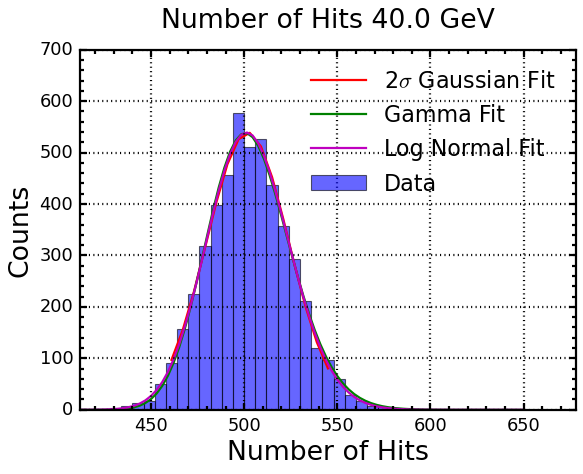

Initial Gamma Fit Parameters: [np.float64(4998.0), np.float64(79.47378932953053), np.float64(454.0820191061187), np.float64(1.6330532212884918)]
Gamma Fit Parameters: [3.47825408e+04 2.14718609e+02 2.27041010e+02 1.66651336e+00]
Gamma Fit Peak: 584.8724404331344 ± 0.353014399057281, Resolution: 0.041752500024431934 ± 0.0003908099527874171
Initial Gaussian Fit Parameters: [5.77000000e+02 4.17525000e-02 5.83205927e+02]
Gaussian Fit Peak: 583.970433357644 ± 0.4005893980133404, Resolution: 0.041390776069280384 ± 0.0007404368613091971
Initial Log Normal Fit Parameters: [5.77000000e+02 1.72649692e-01 2.71638212e+01 5.75229544e+02]
Log Normal Fit Parameters: [3.47889559e+04 4.17547384e-02 2.81128487e-02 5.84264550e+02]
Log Normal Fit Peak: 583.2749093987227 ± 0.34822844968608135, Resolution: 0.041770936254773953 ± 0.0003883873314991624


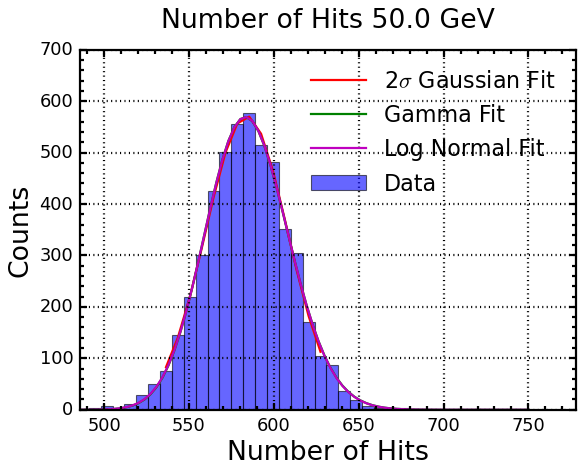

Initial Gamma Fit Parameters: [np.float64(4997.0), np.float64(106.73367611643518), np.float64(587.3356535098972), np.float64(0.6651991194717084)]
Gamma Fit Parameters: [2.96552793e+04 2.06002805e+02 2.93667827e+02 1.77605850e+00]
Gamma Fit Peak: 659.5408598844992 ± 0.5669284338555659, Resolution: 0.038650234028016685 ± 0.0005564384396291862
Initial Gaussian Fit Parameters: [5.14000000e+02 3.86502340e-02 6.57764801e+02]
Gaussian Fit Peak: 658.6557708692969 ± 0.5811381100829819, Resolution: 0.038253972150728704 ± 0.0009533470936846538
Initial Log Normal Fit Parameters: [5.14000000e+02 1.31657555e-01 1.75616669e+01 6.52653762e+02]
Log Normal Fit Parameters: [2.96614552e+04 3.86419298e-02 1.75616677e-02 6.58876677e+02]
Log Normal Fit Peak: 657.9111387600402 ± 0.5543571345896783, Resolution: 0.03865532981022114 ± 0.00054684403309274


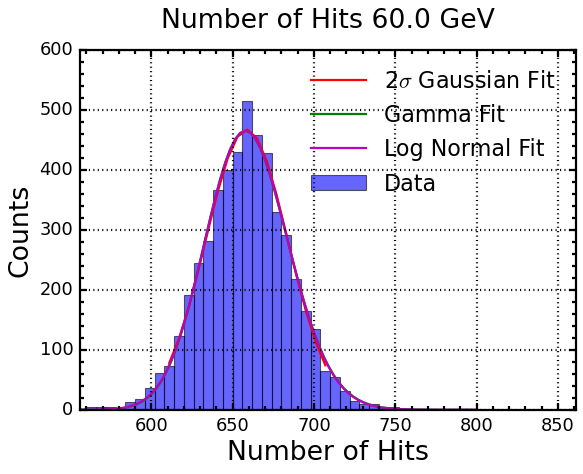

In [11]:
#Fit Number of hits and Save as CSV
results = []
for i_E in range(len(ParticleEnergy)):
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(i_E, "N")    
    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, "NHits_Fit.csv")
df.to_csv(outputfile_name, index=False)

